Simple EWC Experiment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
import random

# --------- 1. Base MLP ---------
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

# --------- 2. Permuted MNIST Loader ---------
class PermutedMNIST(Dataset):
    def __init__(self, perm, train=True):
        mnist = datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor())
        self.data = mnist.data.float().view(-1, 784) / 255.0
        self.targets = mnist.targets
        self.perm = perm

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = self.data[idx][self.perm]
        y = self.targets[idx]
        return x, y

def get_permuted_loaders(perm, batch_size=64):
    train_loader = DataLoader(PermutedMNIST(perm, train=True), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(PermutedMNIST(perm, train=False), batch_size=1000)
    return train_loader, test_loader

# --------- 3. EWC Class ---------
class EWC:
    def __init__(self, model: nn.Module, dataloader, device='cpu'):
        self.model = model
        self.device = device
        self.model.eval()
        self.params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher(dataloader)

    def _compute_fisher(self, dataloader):
        fisher = {n: torch.zeros_like(p, device=self.device) for n, p in self.model.named_parameters() if p.requires_grad}
        criterion = nn.CrossEntropyLoss()

        for inputs, labels in dataloader:
            self.model.zero_grad()
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.data.pow(2)

        for n in fisher:
            fisher[n] /= len(dataloader)

        return fisher

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                _loss = self.fisher[n] * (p - self.params[n]).pow(2)
                loss += _loss.sum()
        return loss

# --------- 4. Training with EWC ---------
def train(model, train_loader, ewc=None, lam=1000, epochs=5):
    model.train()  # Set the model to training mode
    opt = optim.SGD(model.parameters(), lr=0.01)  # Initialize optimizer
    ce_loss = nn.CrossEntropyLoss()  # Initialize loss function

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = ce_loss(outputs, targets)

            # Calculate and apply EWC penalty
            if ewc:
                ewc_penalty = 0
                for ewc_instance in ewc:  # Iterate over EWC instances
                    ewc_penalty += ewc_instance.penalty(model)
                loss += lam * ewc_penalty

            loss.backward()
            opt.step()

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
    return correct / total


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

task_perms = [torch.randperm(784) for _ in range(5)]
ewc_memory = []
accuracies = []

for task_idx, perm in enumerate(task_perms):
    print(f"\n🔁 Training on Task {task_idx + 1}")
    train_loader, test_loader = get_permuted_loaders(perm)

    # Apply EWC from previous tasks if available
    if task_idx > 0:
        train(model, train_loader, ewc=ewc_memory, epochs=5) # Pass list of EWC instances
    else:
        train(model, train_loader, epochs=5)

    # Store EWC data
    ewc_memory.append(EWC(copy.deepcopy(model), train_loader))

    # Evaluate on all tasks so far
    task_accuracies = []
    for i, p in enumerate(task_perms[:task_idx + 1]):
        _, test_loader = get_permuted_loaders(p)
        acc = test(model, test_loader)
        task_accuracies.append(acc)
        print(f"✅ Accuracy on Task {i + 1}: {acc:.4f}")
    accuracies.append(task_accuracies)



🔁 Training on Task 1
✅ Accuracy on Task 1: 0.9160

🔁 Training on Task 2
✅ Accuracy on Task 1: 0.9062
✅ Accuracy on Task 2: 0.9178

🔁 Training on Task 3
✅ Accuracy on Task 1: 0.8918
✅ Accuracy on Task 2: 0.8990
✅ Accuracy on Task 3: 0.9147

🔁 Training on Task 4
✅ Accuracy on Task 1: 0.8889
✅ Accuracy on Task 2: 0.8858
✅ Accuracy on Task 3: 0.8865
✅ Accuracy on Task 4: 0.9085

🔁 Training on Task 5
✅ Accuracy on Task 1: 0.8879
✅ Accuracy on Task 2: 0.8770
✅ Accuracy on Task 3: 0.8709
✅ Accuracy on Task 4: 0.8680
✅ Accuracy on Task 5: 0.9102


In [ ]:
def train(model, train_loader, test_loader, ewc=None, lam=1000, epochs=5):
    model.train()
    opt = optim.SGD(model.parameters(), lr=0.01)
    ce_loss = nn.CrossEntropyLoss()
    epoch_accuracies = []

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = ce_loss(outputs, targets)

            if ewc:
                ewc_penalty = sum([ewc_i.penalty(model) for ewc_i in ewc])
                loss += lam * ewc_penalty

            loss.backward()
            opt.step()

        # Accuracy after this epoch
        acc = test(model, test_loader)
        epoch_accuracies.append(acc)

    return epoch_accuracies


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

task_perms = [torch.randperm(784) for _ in range(5)]
ewc_memory = []
all_epoch_accs = []  # To store epoch-wise accuracies for each task

for task_idx, perm in enumerate(task_perms):
    print(f"\n🔁 Training on Task {task_idx + 1}")
    train_loader, test_loader = get_permuted_loaders(perm)

    if task_idx > 0:
        epoch_accs = train(model, train_loader, test_loader, ewc=ewc_memory, epochs=20)
    else:
        epoch_accs = train(model, train_loader, test_loader, epochs=20)

    all_epoch_accs.append(epoch_accs)  # Save accuracies for this task

    # Store EWC data
    ewc_memory.append(EWC(copy.deepcopy(model), train_loader))

    # Evaluate on all tasks seen so far
    for i, p in enumerate(task_perms[:task_idx + 1]):
        _, eval_loader = get_permuted_loaders(p)
        acc = test(model, eval_loader)
        print(f"✅ Accuracy on Task {i + 1}: {acc:.4f}")



🔁 Training on Task 1
✅ Accuracy on Task 1: 0.9496

🔁 Training on Task 2
✅ Accuracy on Task 1: 0.9467
✅ Accuracy on Task 2: 0.9510

🔁 Training on Task 3
✅ Accuracy on Task 1: 0.9388
✅ Accuracy on Task 2: 0.9406
✅ Accuracy on Task 3: 0.9479

🔁 Training on Task 4
✅ Accuracy on Task 1: 0.9440
✅ Accuracy on Task 2: 0.9388
✅ Accuracy on Task 3: 0.9162
✅ Accuracy on Task 4: 0.9403

🔁 Training on Task 5
✅ Accuracy on Task 1: 0.9389
✅ Accuracy on Task 2: 0.9332
✅ Accuracy on Task 3: 0.9121
✅ Accuracy on Task 4: 0.8939
✅ Accuracy on Task 5: 0.9365


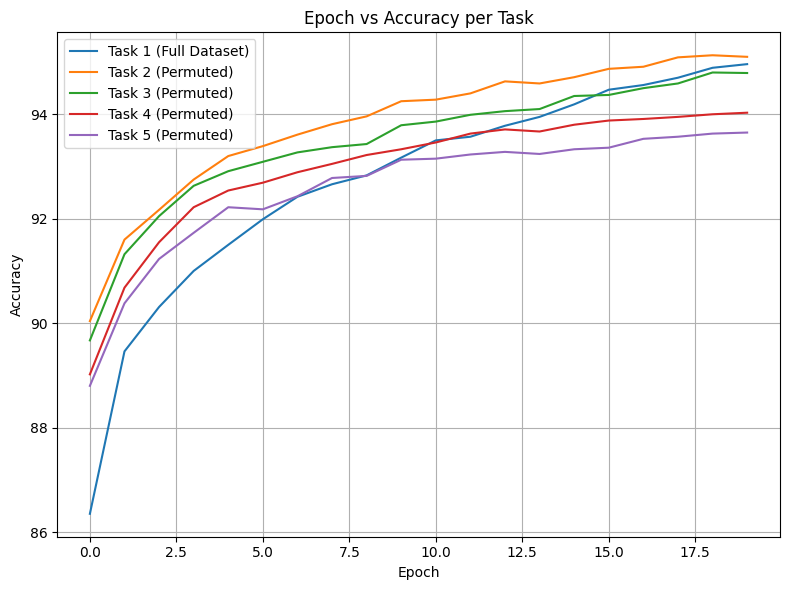

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i, accs in enumerate(all_epoch_accs):
    label = f"Task {i+1}" + (" (Full Dataset)" if i == 0 else " (Permuted)")
    plt.plot(range(len(accs)), [a * 100 for a in accs], label=label)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy per Task")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Code with only 2 tasks:


🔁 Training on Task 1
✅ Accuracy on Task 1: 0.9482

🔁 Training on Task 2
✅ Accuracy on Task 1: 0.9465
✅ Accuracy on Task 2: 0.9498


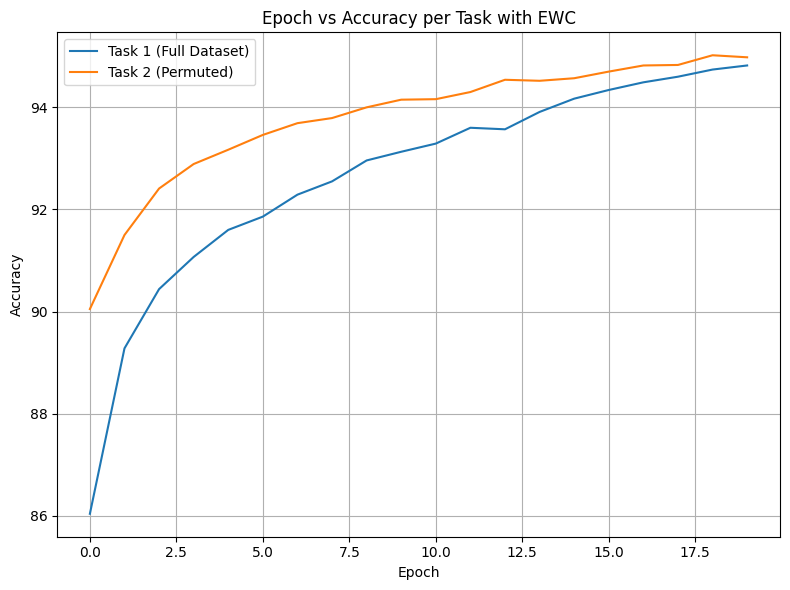

In [ ]:


# --------- MLP ---------
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

# --------- Permuted MNIST ---------
class PermutedMNIST(Dataset):
    def __init__(self, perm, train=True):
        mnist = datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor())
        self.data = mnist.data.float().view(-1, 784) / 255.0
        self.targets = mnist.targets
        self.perm = perm

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = self.data[idx][self.perm]
        y = self.targets[idx]
        return x, y

def get_permuted_loaders(perm, batch_size=64):
    train_loader = DataLoader(PermutedMNIST(perm, train=True), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(PermutedMNIST(perm, train=False), batch_size=1000)
    return train_loader, test_loader

# --------- EWC ---------
class EWC:
    def __init__(self, model: nn.Module, dataloader, device='cpu'):
        self.model = copy.deepcopy(model)
        self.device = device
        self.model.eval()
        self.params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher(dataloader)

    def _compute_fisher(self, dataloader):
        fisher = {n: torch.zeros_like(p, device=self.device) for n, p in self.model.named_parameters() if p.requires_grad}
        criterion = nn.CrossEntropyLoss()
        for inputs, labels in dataloader:
            self.model.zero_grad()
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.data.pow(2)
        for n in fisher:
            fisher[n] /= len(dataloader)
        return fisher

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                _loss = self.fisher[n] * (p - self.params[n]).pow(2)
                loss += _loss.sum()
        return loss

# --------- Training ---------
def train(model, train_loader, test_loader, ewc=None, lam=1000, epochs=20):
    model.train()
    opt = optim.SGD(model.parameters(), lr=0.01)
    ce_loss = nn.CrossEntropyLoss()
    epoch_accuracies = []

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = ce_loss(outputs, targets)

            if ewc:
                ewc_penalty = sum([ewc_i.penalty(model) for ewc_i in ewc])
                loss += lam * ewc_penalty

            loss.backward()
            opt.step()

        # Accuracy after each epoch
        acc = test(model, test_loader)
        epoch_accuracies.append(acc)

    return epoch_accuracies

# --------- Testing ---------
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
    return correct / total

# --------- Main Execution ---------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
task_perms = [torch.randperm(784) for _ in range(2)]
ewc_memory = []
all_epoch_accs = []

for task_idx, perm in enumerate(task_perms):
    print(f"\n🔁 Training on Task {task_idx + 1}")
    train_loader, test_loader = get_permuted_loaders(perm)

    if task_idx > 0:
        epoch_accs = train(model, train_loader, test_loader, ewc=ewc_memory, epochs=20)
    else:
        epoch_accs = train(model, train_loader, test_loader, epochs=20)

    all_epoch_accs.append(epoch_accs)
    ewc_memory.append(EWC(model, train_loader, device=device))

    # Final accuracy for each task so far
    for i, p in enumerate(task_perms[:task_idx + 1]):
        _, test_loader_eval = get_permuted_loaders(p)
        acc = test(model, test_loader_eval)
        print(f"✅ Accuracy on Task {i + 1}: {acc:.4f}")

# --------- Plotting ---------
plt.figure(figsize=(8, 6))
for i, accs in enumerate(all_epoch_accs):
    label = f"Task {i+1}" + (" (Full Dataset)" if i == 0 else " (Permuted)")
    plt.plot(range(len(accs)), [a * 100 for a in accs], label=label)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy per Task with EWC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
